In [6]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn import linear_model
# If your interested ... 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [16]:
# #############################################################################
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


In [17]:
# #############################################################################
# Generate datasets for illustrative purposes
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.20], [0.83, .20]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

In [18]:
# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with\n diff covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    alpha = 0.5

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', alpha=alpha,
             color='red', markeredgecolor='k')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '*', alpha=alpha,
             color='#990000', markeredgecolor='k')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', alpha=alpha,
             color='blue', markeredgecolor='k')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '*', alpha=alpha,
             color='#000099', markeredgecolor='k')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='black', markersize=10, markeredgecolor='k')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='black', markersize=10, markeredgecolor='k')

    return splot


In [78]:
def plot_data_pca(X,Y,fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Principle Component Analysis')
        plt.ylabel('Data with\n fixed covariance')
    elif fig_index == 3:
        plt.ylabel('Data with\n diff covariances')
    #number of principle analysis=1
    #for noise deduction
    #generate the classification line
    pca=PCA(n_components=1)
    pca.fit(X)
    x_reduction=pca.transform(X)
    x_restore=pca.inverse_transform(x_reduction)
    plt.scatter(x_restore[:,0],x_restore[:,1])
    #nuber of principle analysis=2
    #generate the classification scatter result
    #not required for the inclass assignment
    #but good to show since this visualizes the result clearer than ncomp=1
    pca=PCA(n_components=2)
    pca.fit(X)
    x_reduction=pca.transform(X)
    for i in range(len(x_reduction)):
        plt.scatter(x_reduction[Y==i,0],x_reduction[Y==i,1],alpha=0.5)
        
    return splot

In [79]:
def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariance_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariance_[1], 'blue')



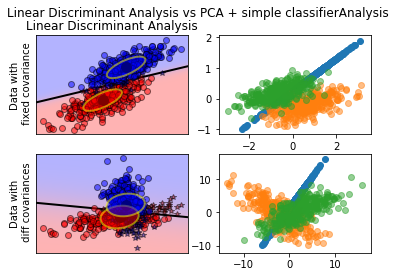

In [80]:
for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')
    
    # Run PCA, Train Linear Classifier
    regr = linear_model.LinearRegression()
    pca = PCA(n_components=1)
    X_r = pca.fit(X).transform(X)
    regr.fit(X_r, y)
    y_pred = regr.predict(X_r)
    plot_data_pca(X,y,fig_index=2 * i + 2)
    plt.axis('tight')
    
    '''
    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis()
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis('tight')
    '''
    
plt.suptitle('Linear Discriminant Analysis vs PCA + simple classifier'
             'Analysis')
plt.show()

# Take Home Part

In [1]:
from sklearn import datasets
from scipy import stats
iris = datasets.load_iris()

## 2a

In [4]:
#symmetric KL Divergence (dij)

feature1=iris.data[:,0]

feature2=iris.data[:,1]

kl12=stats.entropy(feature1,feature2)

feature3=iris.data[:,2]

feature4=iris.data[:,3]

kl34=stats.entropy(feature1,feature3)

kl13=stats.entropy(feature3,feature4)

print("symmetric KL Divergence (dij) between feature 1 and 2 is: ",kl12)
print("symmetric KL Divergence (dij) between feature 3 and 4 is: ",kl34)
print("symmetric KL Divergence (dij) between feature 1 and 3 is: ",kl13)

symmetric KL Divergence (dij) between feature 1 and 2 is:  0.02202723918984858
symmetric KL Divergence (dij) between feature 3 and 4 is:  0.09013557003510748
symmetric KL Divergence (dij) between feature 1 and 3 is:  0.042493426281959075


In [15]:
#Fisher Discriminant Ratio
X12=iris.data[:,[0,1]]
X34=iris.data[:,[2,3]]
X13=iris.data[:,[1,2]]

pca=PCA(n_components=1)
pca.fit(X12)
fd12=pca.explained_variance_ratio_
print('feature 1 and 2 explained variance ratio: %s'
      % str(fd12))

pca=PCA(n_components=1)
pca.fit(X34)
fd34=pca.explained_variance_ratio_
print('feature 3 and 4 explained variance ratio: %s'
      % str(fd34))

pca=PCA(n_components=1)
pca.fit(X13)
fd13=pca.explained_variance_ratio_
print('feature 1 and 3 explained variance ratio: %s'
      % str(fd13))

feature 1 and 2 explained variance ratio: [0.78716571]
feature 3 and 4 explained variance ratio: [0.99025066]
feature 1 and 3 explained variance ratio: [0.95363267]


In [16]:
#Bhattacharyya Distance (B) Continued
import math
def mean( hist ):
    mean = 0.0;
    for i in hist:
        mean += i;
    mean/= len(hist);
    return mean;

def bhatta ( hist1,  hist2):
    # calculate mean of hist1
    h1_ = mean(hist1);

    # calculate mean of hist2
    h2_ = mean(hist2);

    # calculate score
    score = 0;
    for i in range(8):
        score += math.sqrt( hist1[i] * hist2[i] );
    # print h1_,h2_,score;
    score = math.sqrt( 1 - ( 1 / math.sqrt(h1_*h2_*8*8) ) * score );
    return score;

In [17]:
#Continued
bd12 = bhatta(feature1,feature2)
print("Bhattacharyya Distance betwen 1 and 2 ",bd12)

bd34 = bhatta(feature3,feature4)
print("Bhattacharyya Distance betwen 3 and 4 ",bd34)

bd13 = bhatta(feature1, feature3)
print("Bhattacharyya Distance betwen 1 and 3 ",bd13)

Bhattacharyya Distance betwen 1 and 2  0.18764868954815161
Bhattacharyya Distance betwen 3 and 4  0.8516452581160332
Bhattacharyya Distance betwen 1 and 3  0.6562863013485999


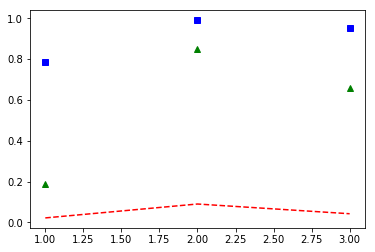

In [18]:
plt.plot([1,2,3], [kl12,kl34,kl13], 'r--')
plt.plot([1,2,3], [fd12,fd34,fd13], 'bs')
plt.plot([1,2,3], [bd12,bd34,bd13], 'g^')

In [122]:
#2b
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


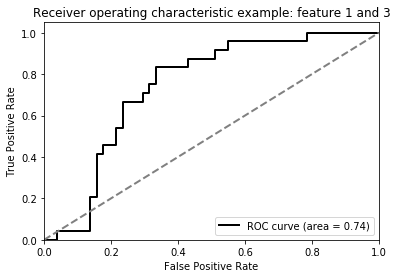

In [141]:
## 2b
# Import some data to play with
iris = datasets.load_iris()

#X = iris.data[:,[0,1]] 
#feature 1 and 2

#X = iris.data[:,[2,3]] 
#feature 3 and 4

X = iris.data[:,[0,2]]
#feature 1 and 3

y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



#Display
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='black',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example: feature 1 and 3')
plt.legend(loc="lower right")
plt.show()

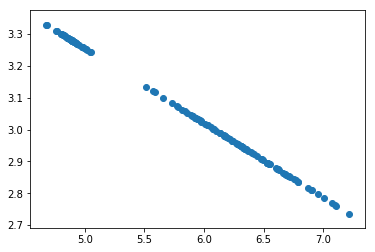

In [173]:
## 2c
iris = datasets.load_iris()

x = iris.data
from sklearn.decomposition import PCA
pca=PCA(n_components=1)
pca.fit(x)
x_reduction=pca.transform(x)
x_restore=pca.inverse_transform(x_reduction)   #conclude all four features and build the 2-D euclidean visualization
plt.scatter(x_restore[:,0],x_restore[:,1])
plt.show()


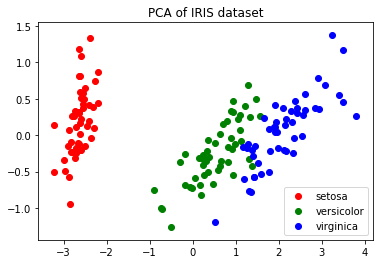

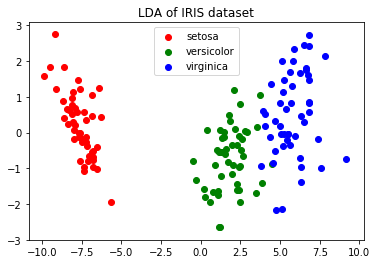

In [179]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=4)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=4)
X_r2 = lda.fit(X, y).transform(X)


plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PCA of IRIS dataset')

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA of IRIS dataset')

plt.show()

In [180]:
# Percentage of variance explained for each components
print('explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio: [0.92461872 0.05306648 0.01710261 0.00521218]


In [181]:
# Percentage of variance explained for each components
print('explained variance ratio: %s'
      % str(lda.explained_variance_ratio_))


explained variance ratio: [0.9912126 0.0087874]
